# WEEK 5

In [1]:
!pip install geopy
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


# Get the Data and do Data Cleaning

In [31]:
import bs4 as bs
#Getting the data from url as table
url = "https://www.dasoertliche.de/Themen/Postleitzahlen/Aachen.html"
res = requests.get(url)
soup = bs.BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))
aachen = pd.read_json(df[0].to_json(orient='records'))
a=aachen['Ortsteil'].replace([None],'Aachenzentrum')
aachen['Ortsteil']=a
aachen=aachen[aachen['Ortsname'].str.contains('Aachen')]
aachen


,PLZ,Ortsname,Ortsteil,Landkreis,Bundesland
0,52062,Aachen,Aachenzentrum,Städteregion Aachen,Nordrhein-Westfalen
1,52064,Aachen,Aachenzentrum,Städteregion Aachen,Nordrhein-Westfalen
2,52066,Aachen,Aachenzentrum,Städteregion Aachen,Nordrhein-Westfalen
3,52068,Aachen,Aachenzentrum,Städteregion Aachen,Nordrhein-Westfalen
4,52070,Aachen,HaarenLaurensberg,Städteregion Aachen,Nordrhein-Westfalen
5,52072,Aachen,HorbachLaurensbergRichterich,Städteregion Aachen,Nordrhein-Westfalen
6,52074,Aachen,LaurensbergOrsbachVaalserquartier,Städteregion Aachen,Nordrhein-Westfalen
7,52076,Aachen,BrandKornelimünsterKrauthausenLichtenbuschNüth...,Städteregion Aachen,Nordrhein-Westfalen
8,52078,Aachen,Brand,Städteregion Aachen,Nordrhein-Westfalen
9,52080,Aachen,EilendorfHaarenVerlautenheide,Städteregion Aachen,Nordrhein-Westfalen


In [32]:
aachen.describe()

,PLZ
count,12.000000
mean,52071.500000
std,5.664884
min,52062.000000
25%,52067.500000
50%,52072.000000
75%,52076.000000
max,52080.000000


# Get Coordinates

In [33]:
!pip install geocoder
import geocoder
print('Libraries imported')


Libraries imported


In [34]:
def get_coor(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Aachen'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords


# Add the Laitude and Longitude to the DataFrame

In [35]:
coor=[]
for postal_code in aachen['PLZ']:
    coor.append(get_coor(postal_code)) 


### translate it to dataframe

In [36]:
df_coor = pd.DataFrame(coor, columns=['Latitude', 'Longitude'])
aachen['Latitude']=df_coor.Latitude
aachen['Longitude']=df_coor.Longitude


# Generate the map for all information

In [37]:
address = 'Aachen Germany'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Aachen are {}, {}.'.format(latitude, longitude))

#generate the map
map_all = folium.Map(location=[latitude, longitude], zoom_start=11)

#add the information to the map
for lat, lng,  neighborhood in zip(aachen['Latitude'], aachen['Longitude'], aachen['Ortsteil']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#87cefa',
        fill_opacity=0.5,
        parse_html=False).add_to(map_all)

map_all

The geograpical coordinate of Aachen are 50.776351, 6.083862.


# From foursquares API get information

In [38]:
CLIENT_ID = 'QLIG0BYDFX3RBMDN05HUML4KMEUGXG0GZ3JF5W52MDQCTVP5' # your Foursquare ID
CLIENT_SECRET = 'WLZANSILPIENAAU2GOZVT05KQ4LFPM5F0M3Z2OLO15PGEYAJ' # your Foursquare Secret
ACCESS_TOKEN = 'SCVBE0OVGQB4CH1TIPYSR1WQ2WBK0XIEBVM3NU2XPBCUBWIO' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([( name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [39]:
aachen_venues = getNearbyVenues(names=aachen['Ortsteil'],
                                   latitudes=aachen['Latitude'],
                                   longitudes=aachen['Longitude']
                                  )

Aachenzentrum
Aachenzentrum
Aachenzentrum
Aachenzentrum
HaarenLaurensberg
HorbachLaurensbergRichterich
LaurensbergOrsbachVaalserquartier
BrandKornelimünsterKrauthausenLichtenbuschNütheimSchleckheimSchmithof
Brand
EilendorfHaarenVerlautenheide
Horbach Stadt Aachen
Friesenrath Stadt Aachen


In [40]:
aachen_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aachenzentrum,50.77641,6.08589,Katschhof,50.775611,6.083909,Plaza
1,Aachenzentrum,50.77641,6.08589,BURGERISTA,50.776384,6.084331,Burger Joint
2,Aachenzentrum,50.77641,6.08589,AKL,50.776967,6.083277,Falafel Restaurant
3,Aachenzentrum,50.77641,6.08589,Aachener Dom St. Marien,50.774702,6.084103,Church
4,Aachenzentrum,50.77641,6.08589,Rathaus,50.776378,6.083880,City Hall


In [41]:
# one hot encoding
aachen_onehot = pd.get_dummies(aachen_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
aachen_onehot['Neighbourhood'] = aachen_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [aachen_onehot.columns[-1]] + list(aachen_onehot.columns[:-1])
aachen_onehot = aachen_onehot[fixed_columns]
aachen_onehot.head()

,Neighbourhood,Asian Restaurant,Auto Dealership,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beer Store,Big Box Store,Bistro,Bookstore,Burger Joint,Bus Station,Bus Stop,Café,Chinese Restaurant,Church,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Drugstore,Falafel Restaurant,Farmers Market,Flower Shop,Food & Drink Shop,Furniture / Home Store,Gas Station,Gastropub,German Restaurant,Hobby Shop,Hookah Bar,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Laundromat,Liquor Store,Movie Theater,Music Venue,Park,Pet Store,Pharmacy,Plaza,Pub,Restaurant,Shoe Store,Shopping Mall,Soccer Field,Soccer Stadium,Stadium,Supermarket,Trail,Train Station,Vietnamese Restaurant,Wine Bar
0,Aachenzentrum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Aachenzentrum,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Aachenzentrum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Aachenzentrum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Aachenzentrum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
aachen_onehot.shape

(115, 63)

In [43]:
aachen_grouped = aachen_onehot.groupby('Neighbourhood').mean().reset_index()
aachen_plot=aachen_grouped


In [44]:
#Get the top5 restaurant
num_top_venues = 5

for hood in aachen_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = aachen_grouped[aachen_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aachenzentrum----
               venue  freq
0             Bakery  0.07
1              Hotel  0.06
2  German Restaurant  0.05
3                Bar  0.05
4          Drugstore  0.05


----Brand----
               venue  freq
0          Gastropub   0.5
1     Cosmetics Shop   0.5
2   Asian Restaurant   0.0
3               Park   0.0
4  German Restaurant   0.0


----EilendorfHaarenVerlautenheide----
               venue  freq
0     Ice Cream Shop  0.25
1      Train Station  0.25
2              Plaza  0.25
3           Bus Stop  0.25
4  Indian Restaurant  0.00


----HaarenLaurensberg----
            venue  freq
0           Hotel  0.11
1          Bakery  0.11
2     Bus Station  0.11
3  Soccer Stadium  0.06
4        Pharmacy  0.06


----Horbach Stadt Aachen----
              venue  freq
0          Bus Stop  0.67
1             Diner  0.33
2  Asian Restaurant  0.00
3              Park  0.00
4         Gastropub  0.00


----HorbachLaurensbergRichterich----
              venue  freq
0          B

In [45]:
#put into pandas DF
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [46]:
#top 10
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = aachen_grouped['Neighbourhood']

for ind in np.arange(aachen_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(aachen_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aachenzentrum,Bakery,Hotel,Drugstore,Plaza,German Restaurant,Bar,Italian Restaurant,Bus Stop,Coffee Shop,Café
1,Brand,Gastropub,Cosmetics Shop,Wine Bar,Chinese Restaurant,Drugstore,Diner,Dessert Shop,Deli / Bodega,Cupcake Shop,Concert Hall
2,EilendorfHaarenVerlautenheide,Bus Stop,Train Station,Plaza,Ice Cream Shop,Coffee Shop,Church,City Hall,Clothing Store,Cocktail Bar,Concert Hall
3,HaarenLaurensberg,Bus Station,Bakery,Hotel,BBQ Joint,German Restaurant,Stadium,Soccer Stadium,Soccer Field,Bus Stop,Farmers Market
4,Horbach Stadt Aachen,Bus Stop,Diner,Wine Bar,Chinese Restaurant,Falafel Restaurant,Drugstore,Dessert Shop,Deli / Bodega,Cupcake Shop,Cosmetics Shop


# Cluster

In [48]:
# set number of clusters
kclusters = 7

aachen_grouped_clustering = aachen_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(aachen_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


D:\Users\Hasse\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return_n_iter=True)


In [49]:
aachen_merged = aachen

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
aachen_merged = aachen_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Ortsteil')

aachen_merged.head() # check the last columns!

# create map

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(aachen_merged['Latitude'], aachen_merged['Longitude'], aachen_merged['Ortsteil'],kmeans.labels_):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon], radius=5, popup=label, color=rainbow[cluster-1], fill=True, fill_color=rainbow[cluster-1], fill_opacity=0.7).add_to(map_clusters)
map_clusters

In [53]:
aachen_merged.loc[aachen_merged['Cluster Labels'] == 5, aachen_merged.columns[[1] + list(range(5, aachen_merged.shape[1]))]]


,Ortsname,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aachen,50.77641,6.085890,5.0,Bakery,Hotel,Drugstore,Plaza,German Restaurant,Bar,Italian Restaurant,Bus Stop,Coffee Shop,Café
1,Aachen,50.76824,6.082041,5.0,Bakery,Hotel,Drugstore,Plaza,German Restaurant,Bar,Italian Restaurant,Bus Stop,Coffee Shop,Café
2,Aachen,50.75450,6.099478,5.0,Bakery,Hotel,Drugstore,Plaza,German Restaurant,Bar,Italian Restaurant,Bus Stop,Coffee Shop,Café
3,Aachen,50.77950,6.121089,5.0,Bakery,Hotel,Drugstore,Plaza,German Restaurant,Bar,Italian Restaurant,Bus Stop,Coffee Shop,Café


In [52]:
aachen_merged

,PLZ,Ortsname,Ortsteil,Landkreis,Bundesland,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,52062,Aachen,Aachenzentrum,Städteregion Aachen,Nordrhein-Westfalen,50.776410,6.085890,5.0,Bakery,Hotel,Drugstore,Plaza,German Restaurant,Bar,Italian Restaurant,Bus Stop,Coffee Shop,Café
1,52064,Aachen,Aachenzentrum,Städteregion Aachen,Nordrhein-Westfalen,50.768240,6.082041,5.0,Bakery,Hotel,Drugstore,Plaza,German Restaurant,Bar,Italian Restaurant,Bus Stop,Coffee Shop,Café
2,52066,Aachen,Aachenzentrum,Städteregion Aachen,Nordrhein-Westfalen,50.754500,6.099478,5.0,Bakery,Hotel,Drugstore,Plaza,German Restaurant,Bar,Italian Restaurant,Bus Stop,Coffee Shop,Café
3,52068,Aachen,Aachenzentrum,Städteregion Aachen,Nordrhein-Westfalen,50.779500,6.121089,5.0,Bakery,Hotel,Drugstore,Plaza,German Restaurant,Bar,Italian Restaurant,Bus Stop,Coffee Shop,Café
4,52070,Aachen,HaarenLaurensberg,Städteregion Aachen,Nordrhein-Westfalen,50.790965,6.095144,1.0,Bus Station,Bakery,Hotel,BBQ Joint,German Restaurant,Stadium,Soccer Stadium,Soccer Field,Bus Stop,Farmers Market
5,52072,Aachen,HorbachLaurensbergRichterich,Städteregion Aachen,Nordrhein-Westfalen,50.826941,6.050155,0.0,Bus Stop,Diner,Wine Bar,Chinese Restaurant,Falafel Restaurant,Drugstore,Dessert Shop,Deli / Bodega,Cupcake Shop,Cosmetics Shop
6,52074,Aachen,LaurensbergOrsbachVaalserquartier,Städteregion Aachen,Nordrhein-Westfalen,50.766860,6.045922,4.0,Flower Shop,Trail,Bus Station,Chinese Restaurant,Drugstore,Diner,Dessert Shop,Deli / Bodega,Cupcake Shop,Cosmetics Shop
7,52076,Aachen,BrandKornelimünsterKrauthausenLichtenbuschNüth...,Städteregion Aachen,Nordrhein-Westfalen,50.708715,6.165719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,52078,Aachen,Brand,Städteregion Aachen,Nordrhein-Westfalen,50.756490,6.162285,2.0,Gastropub,Cosmetics Shop,Wine Bar,Chinese Restaurant,Drugstore,Diner,Dessert Shop,Deli / Bodega,Cupcake Shop,Concert Hall
9,52080,Aachen,EilendorfHaarenVerlautenheide,Städteregion Aachen,Nordrhein-Westfalen,50.786631,6.150915,3.0,Bus Stop,Train Station,Plaza,Ice Cream Shop,Coffee Shop,Church,City Hall,Clothing Store,Cocktail Bar,Concert Hall


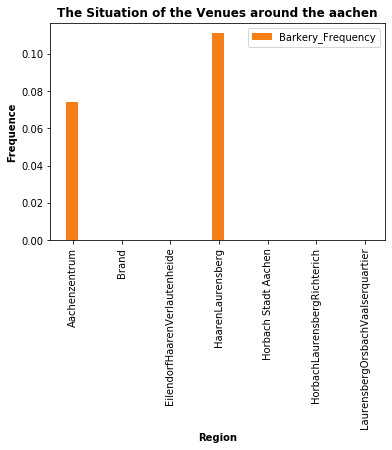

In [54]:
import matplotlib.pyplot as plt
Bakery=aachen_plot['Bakery']
barWidth = 0.25
pos = np.arange(len(aachen_plot.Neighbourhood))
plt.bar(pos,aachen_plot.Bakery,Width=barWidth, color='#F57F17')
plt.title('The Situation of the Venues around the aachen', fontweight='bold')
plt.ylabel('Frequence', fontweight='bold')
plt.xlabel('Region', fontweight='bold')
plt.legend(labels = ['Barkery_Frequency'],loc='best')
plt.xticks([i-barWidth for i in range(len(aachen_plot.Neighbourhood))],aachen_plot.Neighbourhood,rotation=90)
plt.show()

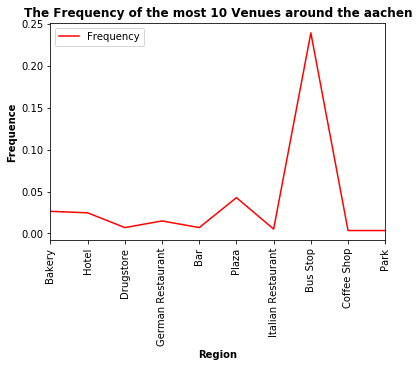

In [55]:
info=['Bakery','Hotel','Drugstore','German Restaurant','Bar','Plaza','Italian Restaurant','Bus Stop','Coffee Shop','Park']
info1=aachen_plot[info].mean().to_frame() 
info1.plot(color='r')
plt.title('The Frequency of the most 10 Venues around the aachen', fontweight='bold')
plt.ylabel('Frequence', fontweight='bold')
plt.xlabel('Region', fontweight='bold')
plt.xticks(rotation=90)
plt.legend(labels = ['Frequency'],loc='best')
plt.show()